<h1>Detecting signs of depression using reddit data</h1>

<h1>LIBRARIES USED</h1>


In [1]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Suicide_Detection.csv')
data.head()

Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

In [3]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [4]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

<h1>DATA-SET SPLIT</h1>


In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

<h1>DATA VISUALISATIONS</h1>


In [6]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [7]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])

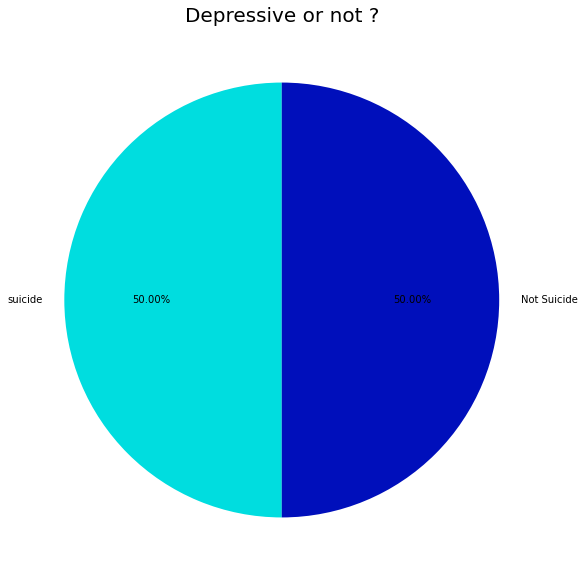

In [34]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('Depressive or not ?',fontdict={'size':20})
plt.show()

<h1>DATA CLEANING</h1>


In [9]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [10]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|█████████████████████████████████████████████████████████████████████████| 46415/46415 [00:02<00:00, 17058.26it/s]


In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [13]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

In [35]:
word_freq

word   count
35                  im  261569
21                dont  170560
8                 like  143810
29                want  118837
28                know  103925
...                ...     ...
138279       startonce       1
138280        leafless       1
138281       branchesa       1
138282  wolverinestyle       1
271867          roomin       1

[271868 rows x 2 columns]

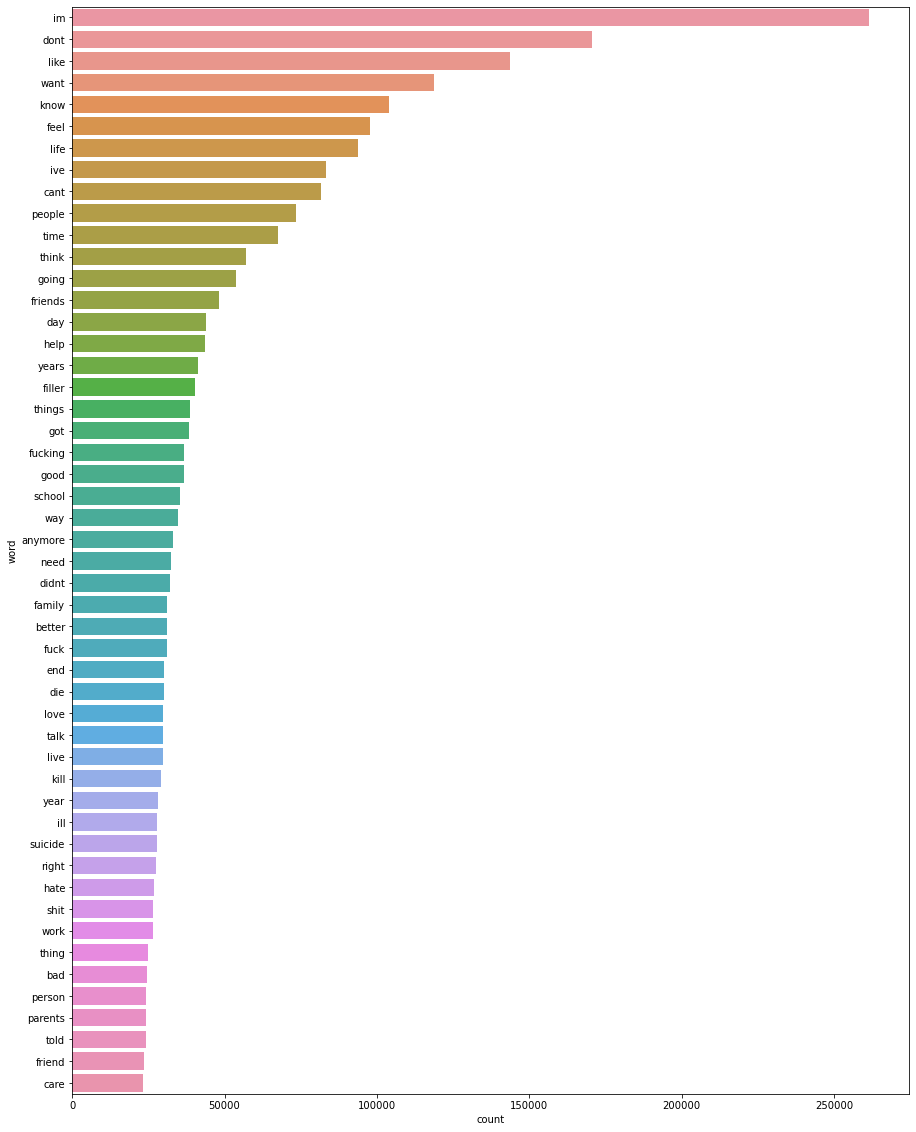

In [14]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

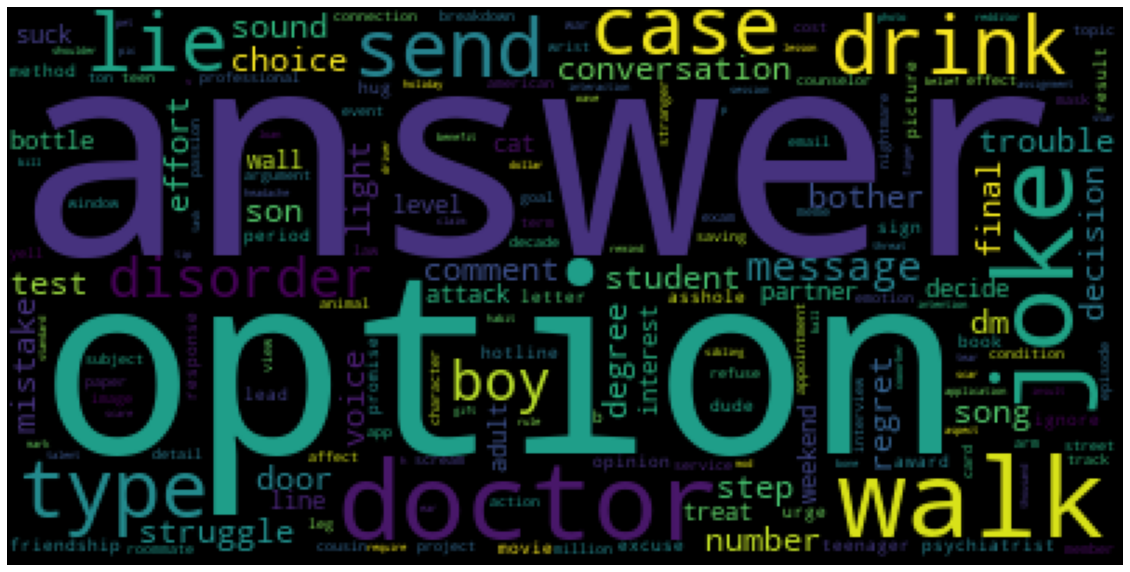

In [15]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

<h1>PREPROCESSING TEXT DATA</h1>


In [16]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [17]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

<h1>GLOVE EMBEDDINGS</h1>


In [18]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [20]:
# glove_embedding={}
with open('glove.840B.300d.pkl~1\glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [21]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

<h1>MODEL BUILDING</h1>


In [27]:
model=Sequential()

model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,batch_input_shape=(None,40),return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 46s 59ms/step - loss: 0.3413 - accuracy: 0.8540 - val_loss: 0.2908 - val_accuracy: 0.8816 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 44s 61ms/step - loss: 0.2449 - accuracy: 0.9018 - val_loss: 0.2270 - val_accuracy: 0.9099 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 45s 61ms/step - loss: 0.2261 - accuracy: 0.9107 - val_loss: 0.2204 - val_accuracy: 0.9135 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 45s 62ms/step - loss: 0.2144 - accuracy: 0.9157 - val_loss: 0.2067 - val_accuracy: 0.9197 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 43s 59ms/step - loss: 0.2034 - accuracy: 0.9205 - val_loss: 0.2034 - val_accuracy: 0.9212 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 48s 67ms/step - loss: 0.1936 - accuracy: 0.9248 - val_loss: 0.1963 - val_accuracy: 0.9235 - lr: 0.1000
Epoch 7/20
726/726 [==============================] - 47s 

<h1>MODEL EVALUATION</h1>


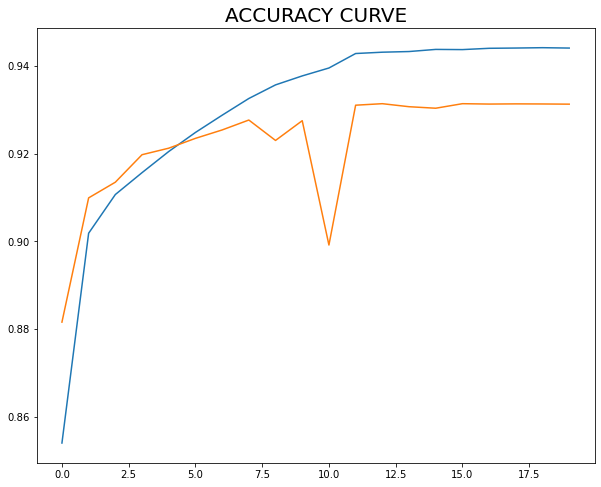

In [29]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

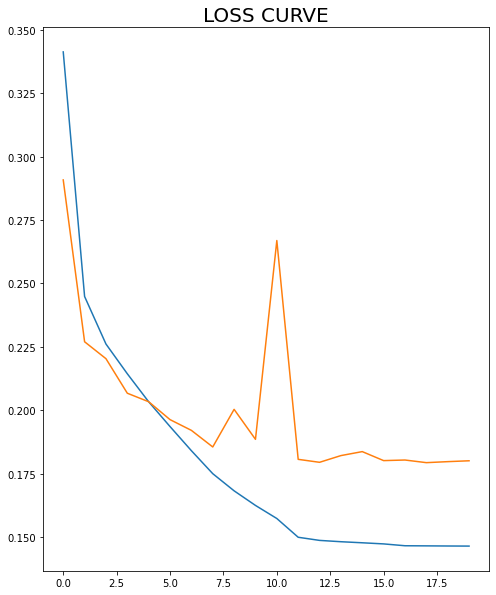

In [30]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [33]:
#prediction and classification report 

Predict_Class = (model.predict(test_text_pad) > 0.5).astype("int32")
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, Predict_Class,target_names=lbl_target.inverse_transform([0,1])))



1451/1451 [==============================] - 12s 8ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.93     23209
     suicide       0.94      0.92      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

